<a href="https://colab.research.google.com/github/jkarthiknai/mine/blob/main/Loan_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
import operator

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

In [ ]:
df = pd.read_csv("Training.csv")
df.info()
print(len(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111107 entries, 0 to 111106
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       111107 non-null  object 
 1   Customer ID                   111107 non-null  object 
 2   Loan Status                   111107 non-null  object 
 3   Current Loan Amount           111107 non-null  int64  
 4   Term                          111107 non-null  object 
 5   Credit Score                  89769 non-null   float64
 6   Years in current job          106414 non-null  object 
 7   Home Ownership                111107 non-null  object 
 8   Annual Income                 89769 non-null   float64
 9   Purpose                       111107 non-null  object 
 10  Monthly Debt                  111107 non-null  object 
 11  Years of Credit History       111107 non-null  float64
 12  Months since last delinquent  52104 non-null

/tmp/ipython-input-445-1005272643.py:1: DtypeWarning: Columns (10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Training.csv")


In [ ]:
df['Loan ID'].value_counts()

,count
Loan ID,
26e3e4f3-7442-4b68-bc2b-a9c4567f67ce,2
7934a353-b3c5-430e-b7fb-03ff163aac20,2
4e515bf9-3d42-4008-9e7f-0f5b11473156,2
b58e30b1-347e-4f3c-830b-b337635dab22,2
13c34f9c-8546-480a-86b9-69f83568b37c,2
...,...
18cf82cd-f0e6-452e-8429-2a1e70b056ec,1
cead3a3f-1294-4558-9688-60b92eb2d369,1
18e58e4b-90fc-4248-99f6-02ed33e8310f,1


In [ ]:
# There are duplicate observations
# Deleting duplicates
df.drop_duplicates(subset='Loan ID', keep='first', inplace=True)
print(len(df))

88910


<Axes: xlabel='Loan Status', ylabel='count'>

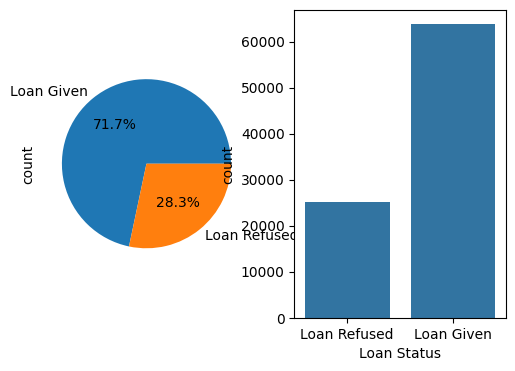

In [ ]:
#Checking for data imbalance
fig, ax = plt.subplots(1,2,figsize=(6,4))
df['Loan Status'].value_counts().plot.pie(autopct = "%1.1f%%", ax=ax[0])
sns.countplot(x='Loan Status', data=df, ax=ax[1])
# Imbalanced data 71.7%:28.3%

In [ ]:
df['Current Loan Amount'].describe()

,Current Loan Amount
count,8.891000e+04
mean,1.433878e+07
std,3.502996e+07
min,4.910000e+02
25%,8.283000e+03
50%,1.435500e+04
75%,2.448500e+04
max,1.000000e+08


In [ ]:
df['Current Loan Amount'].isnull().sum()

np.int64(0)

<Axes: ylabel='Frequency'>

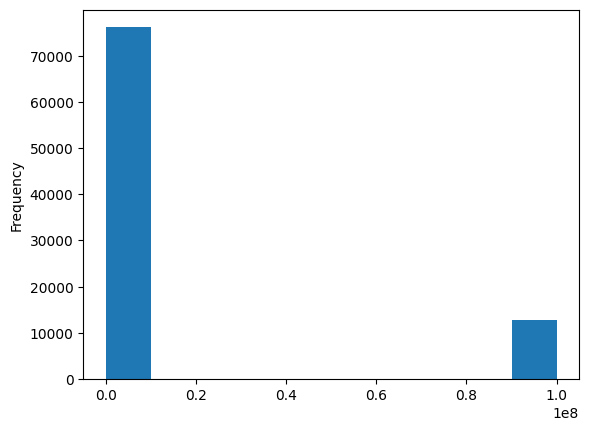

In [ ]:
df['Current Loan Amount'].plot(kind='hist', bins=10)
# A few current high loan amounts

In [ ]:
#Finding interquartile range, lower and upper bound values
q1 = df['Current Loan Amount'].quantile(0.25)
q2 = df['Current Loan Amount'].quantile(0.5)
q3 = df['Current Loan Amount'].quantile(0.75)

iqr = q3 - q1
print(q1, q2, q3, iqr)
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

print(lower)
print(upper)
#There are outliers as the lower bound is has -ve values for this feature

print(df['Current Loan Amount'][(df['Current Loan Amount'] >= lower) &
(df['Current Loan Amount'] <= upper)].value_counts())
print(df['Current Loan Amount'][(df['Current Loan Amount'] >= upper)].value_counts())


8283.0 14355.0 24485.0 16202.0
-16020.0
48788.0
Current Loan Amount
10151    25
8066     23
10156    23
9771     22
9941     22
         ..
23416     1
19074     1
5196      1
31226     1
28988     1
Name: count, Length: 22080, dtype: int64
Current Loan Amount
99999999    12738
Name: count, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88910 entries, 0 to 88909
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       88910 non-null  object 
 1   Customer ID                   88910 non-null  object 
 2   Loan Status                   88910 non-null  object 
 3   Current Loan Amount           88910 non-null  int64  
 4   Term                          88910 non-null  object 
 5   Credit Score                  67572 non-null  float64
 6   Years in current job          85093 non-null  object 
 7   Home Ownership                88910 non-null  object 
 8   Annual Income                 67572 non-null  float64
 9   Purpose                       88910 non-null  object 
 10  Monthly Debt                  88910 non-null  object 
 11  Years of Credit History       88910 non-null  float64
 12  Months since last delinquent  40404 non-null  float64
 13  Number

In [ ]:
df['Loan Status'][df['Current Loan Amount']==99999999].value_counts()
#df.loc[df['Current Loan Amount']==99999999, 'Loan Status'].value_counts()

,count
Loan Status,
Loan Given,12738


In [ ]:
df.loc[df['Current Loan Amount']<99999999, 'Loan Status'].value_counts()

,count
Loan Status,
Loan Given,50999
Loan Refused,25173


In [ ]:
df['Current Loan Amount'].isnull().sum()

np.int64(0)

In [ ]:
df['Current Loan Amount'].describe()

,Current Loan Amount
count,8.891000e+04
mean,1.433878e+07
std,3.502996e+07
min,4.910000e+02
25%,8.283000e+03
50%,1.435500e+04
75%,2.448500e+04
max,1.000000e+08


In [ ]:
df['Current Loan Amount'][df['Current Loan Amount']<99999999].describe()

,Current Loan Amount
count,76172.000000
mean,13933.915756
std,8235.921922
min,491.000000
25%,7810.000000
50%,12038.000000
75%,19351.000000
max,35875.000000


In [ ]:
filt_df = df[(df['Current Loan Amount']!=99999999) & (df['Current Loan Amount'].notnull())]

cor=filt_df[['Annual Income','Months since last delinquent','Number of Credit Problems','Current Credit Balance','Current Loan Amount','Number of Open Accounts', 'Years of Credit History']].corr()
print(cor)

                              Annual Income  Months since last delinquent  \
Annual Income                      1.000000                     -0.079377   
Months since last delinquent      -0.079377                      1.000000   
Number of Credit Problems         -0.006359                      0.098809   
Current Credit Balance             0.276285                     -0.027509   
Current Loan Amount                0.329878                     -0.039258   
Number of Open Accounts            0.134765                     -0.034196   
Years of Credit History            0.142307                     -0.042539   

                              Number of Credit Problems  \
Annual Income                                 -0.006359   
Months since last delinquent                   0.098809   
Number of Credit Problems                      1.000000   
Current Credit Balance                        -0.104818   
Current Loan Amount                           -0.071351   
Number of Open Accounts      

12038.0


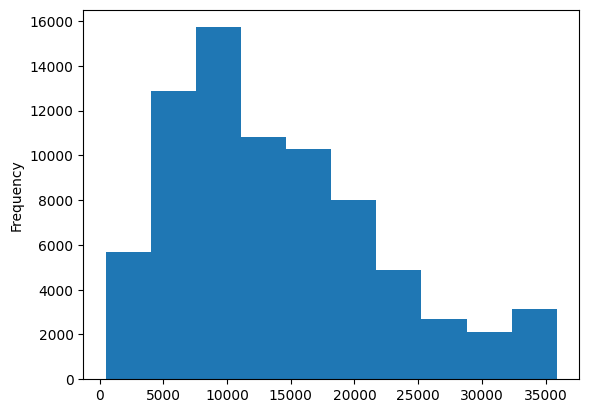

In [ ]:
df.loc[df['Current Loan Amount'] < 99999999]['Current Loan Amount'].plot(kind='hist', bins=10)
print(df[df['Current Loan Amount']<99999999]['Current Loan Amount'].median())

In [ ]:
df['Current Loan Amount'].replace(99999999, np.nan, inplace=True)

In [ ]:
df.isnull().sum()

,0
Loan ID,0
Customer ID,0
Loan Status,0
Current Loan Amount,12738
Term,0
Credit Score,21338
Years in current job,3817
Home Ownership,0
Annual Income,21338
Purpose,0


In [ ]:
df['Loan Status'][df['Current Loan Amount'].isnull()].value_counts()

,count
Loan Status,
Loan Given,12738


In [ ]:
'''#Which of the data fall between lower and upper bound
import numpy as np
import pandas as pd

temp = np.array(df['Current Loan Amount'].values.tolist())
df['Current Loan Amount'] = np.where(temp > 99999998, 12038, temp).tolist()

print(df['Current Loan Amount'][(df['Current Loan Amount'] >= lower) |
(df['Current Loan Amount'] <= upper)].value_counts())...'''

"#Which of the data fall between lower and upper bound\nimport numpy as np\nimport pandas as pd\n\ntemp = np.array(df['Current Loan Amount'].values.tolist())\ndf['Current Loan Amount'] = np.where(temp > 99999998, 12038, temp).tolist()\n\nprint(df['Current Loan Amount'][(df['Current Loan Amount'] >= lower) |\n(df['Current Loan Amount'] <= upper)].value_counts())..."

In [ ]:
len(df)

88910

<Axes: ylabel='Frequency'>

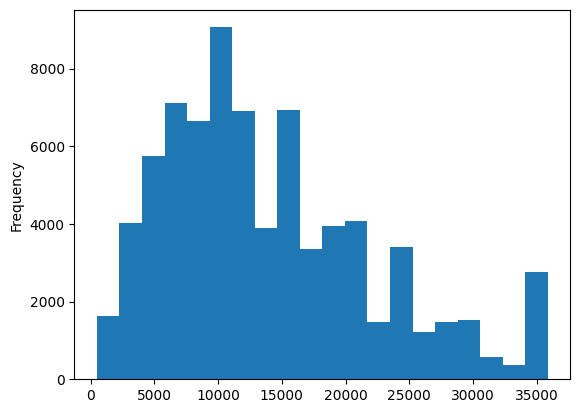

In [ ]:
df['Current Loan Amount'].plot(kind='hist', bins=20)

In [ ]:
# Pewrforming univariate analysis
df['Number of Credit Problems'].value_counts()
# credit problems >=5 can be corrected as 5

,count
Number of Credit Problems,
0,77057
1,10271
2,1092
3,311
4,101
5,46
6,14
7,6
9,4


0


<Axes: xlabel='Term'>

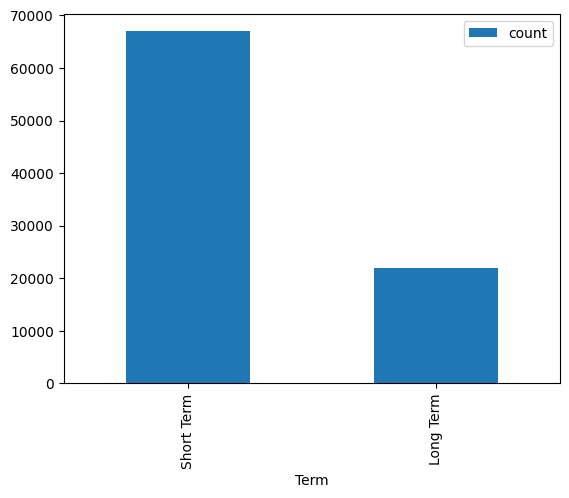

In [ ]:
print(df['Term'].isnull().sum())
df['Term'].value_counts().plot(kind='bar',legend=True)

In [ ]:
df.isnull().sum()

,0
Loan ID,0
Customer ID,0
Loan Status,0
Current Loan Amount,12738
Term,0
Credit Score,21338
Years in current job,3817
Home Ownership,0
Annual Income,21338
Purpose,0


In [ ]:
#finding invalid credit scores
print(df.shape)
print(df['Credit Score'].value_counts())
print(df['Credit Score'][df['Credit Score']>800].value_counts())
print(df['Credit Score'][df['Credit Score']>800].value_counts().sum())

(88910, 19)
Credit Score
747.0     2040
740.0     1954
746.0     1932
741.0     1922
742.0     1911
          ... 
5860.0       1
5880.0       1
6050.0       1
5890.0       1
5920.0       1
Name: count, Length: 326, dtype: int64
Credit Score
7390.0    118
7370.0    111
7400.0    109
7380.0    103
7330.0     97
         ... 
6050.0      1
5960.0      1
6000.0      1
5900.0      1
5860.0      1
Name: count, Length: 159, dtype: int64
5044


In [ ]:
df['Credit Score'].max()

7510.0

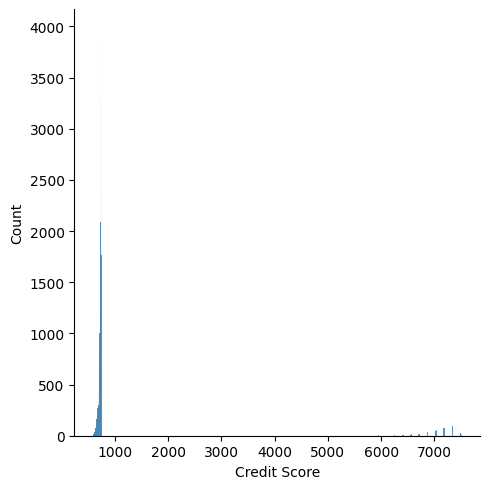

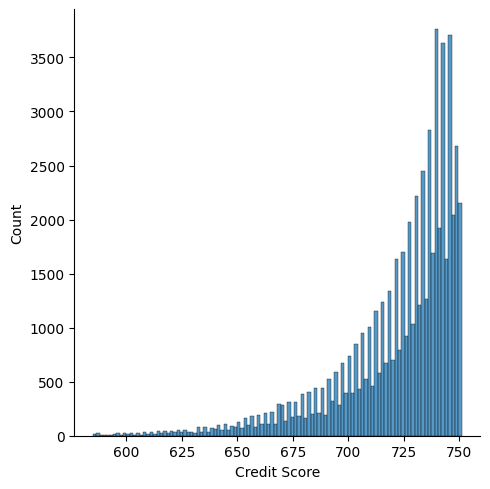

In [ ]:
sns.displot(df['Credit Score'])
sns.displot(df[(df['Credit Score']<=800)]['Credit Score'])

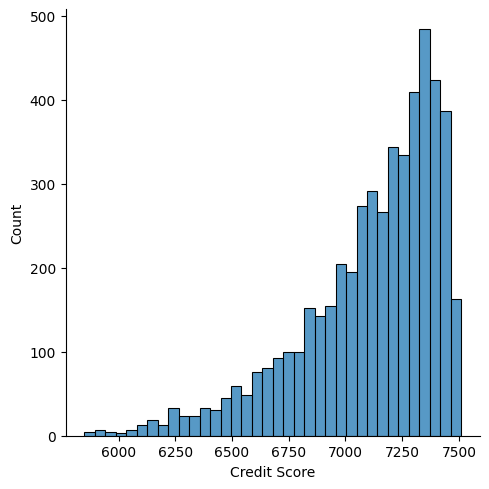

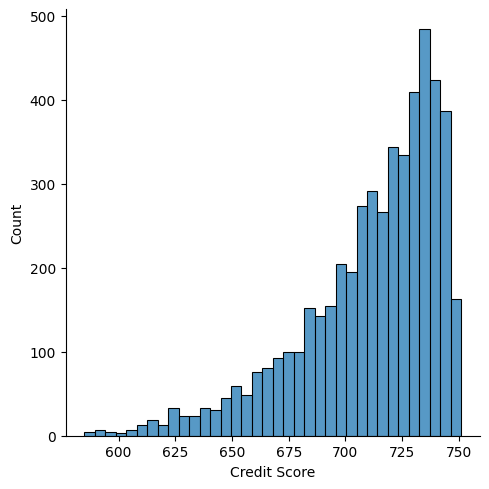

In [ ]:
sns.displot(df[(df['Credit Score']>800)]['Credit Score'])
sns.displot(df[(df['Credit Score']>800)]['Credit Score']/10)

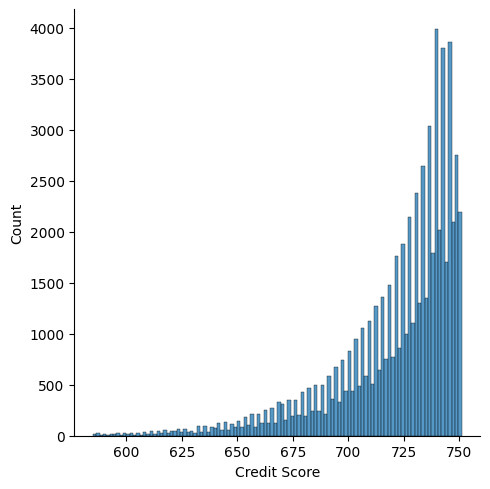

In [ ]:
# Replacing all credit values > 800 with values between 0 to 800
#df['Credit Score'] = np.where(df['Credit Score']>800, df['Credit Score']/10, df['Credit Score'])
df["Credit Score"]=np.where(df["Credit Score"]>800, df['Credit Score']/10, df["Credit Score"])
sns.displot(df['Credit Score'])

721.6019505120464 730.0


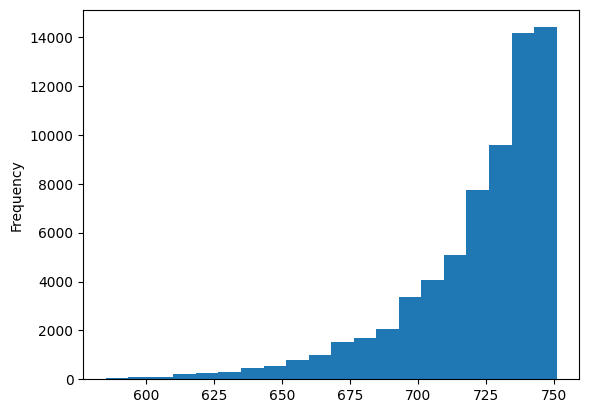

In [ ]:
df['Credit Score'].plot(kind='hist', bins=20)
#skewed, so median
print(df['Credit Score'].mean(), df['Credit Score'].median())

/tmp/ipython-input-476-1436328961.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Credit Score'].fillna(730, inplace = True)


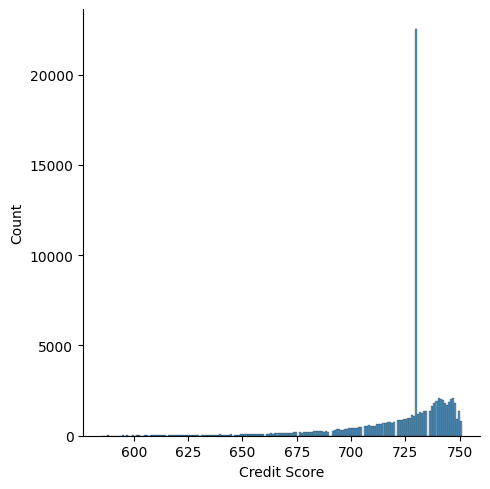

In [ ]:
df1=df[['Credit Score']].copy()
df1['Credit Score'].fillna(730, inplace = True)
sns.displot(df1['Credit Score'])
#When replaced with median, there is steep peak, which results in distortion, hence do not replace with mean or median

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88910 entries, 0 to 88909
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       88910 non-null  object 
 1   Customer ID                   88910 non-null  object 
 2   Loan Status                   88910 non-null  object 
 3   Current Loan Amount           76172 non-null  float64
 4   Term                          88910 non-null  object 
 5   Credit Score                  67572 non-null  float64
 6   Years in current job          85093 non-null  object 
 7   Home Ownership                88910 non-null  object 
 8   Annual Income                 67572 non-null  float64
 9   Purpose                       88910 non-null  object 
 10  Monthly Debt                  88910 non-null  object 
 11  Years of Credit History       88910 non-null  float64
 12  Months since last delinquent  40404 non-null  float64
 13  Number

In [ ]:
df['Credit Score'].isnull().sum()

np.int64(21338)

<Axes: xlabel='Loan Status', ylabel='count'>

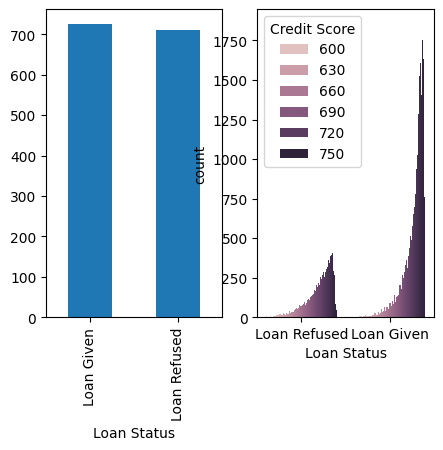

In [ ]:
f, ax=plt.subplots(1,2,figsize=(5,4))
df[['Loan Status','Credit Score']].groupby('Loan Status')['Credit Score'].mean().plot.bar(ax=ax[0])
sns.countplot(x='Loan Status',data=df,ax=ax[1], hue='Credit Score')

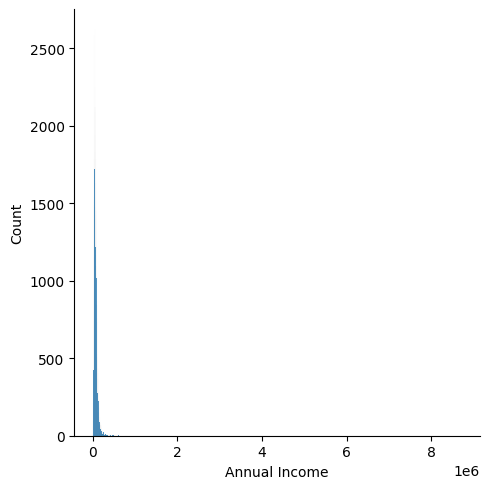

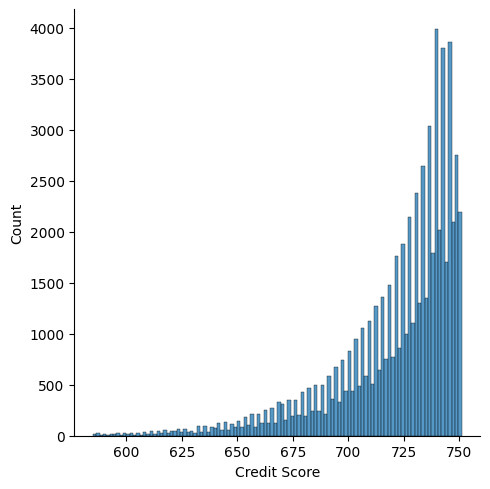

In [ ]:
sns.displot(df['Annual Income'])
sns.displot(df['Credit Score'])

In [ ]:
df[['Annual Income', 'Loan Status']].groupby('Loan Status')['Annual Income'].mean().plot.bar(ax=ax[0])

<Axes: xlabel='Loan Status'>

In [ ]:
df['Home Ownership'].unique()
df['Home Ownership'].value_counts()

,count
Home Ownership,
Home Mortgage,43270
Rent,37395
Own Home,8075
HaveMortgage,170


In [ ]:
df['Home Ownership'] = df['Home Ownership'].str.replace('HaveMortgage','Home Mortgage', regex=True)
df['Home Ownership'].value_counts()

,count
Home Ownership,
Home Mortgage,43440
Rent,37395
Own Home,8075


In [ ]:
df['Annual Income'].isna().sum()
df['Annual Income'].isnull().value_counts()

,count
Annual Income,
False,67572
True,21338


In [ ]:
df[['Credit Score','Annual Income']].isnull().sum()

,0
Credit Score,21338
Annual Income,21338


Loan Status,Loan Given,Loan Refused
Years in current job,,
1 year,4098,1667
10+ years,19966,7444
2 years,5967,2220
3 years,5297,1966
4 years,3926,1548
5 years,4378,1706
6 years,3630,1465
7 years,3508,1435
8 years,2920,1178


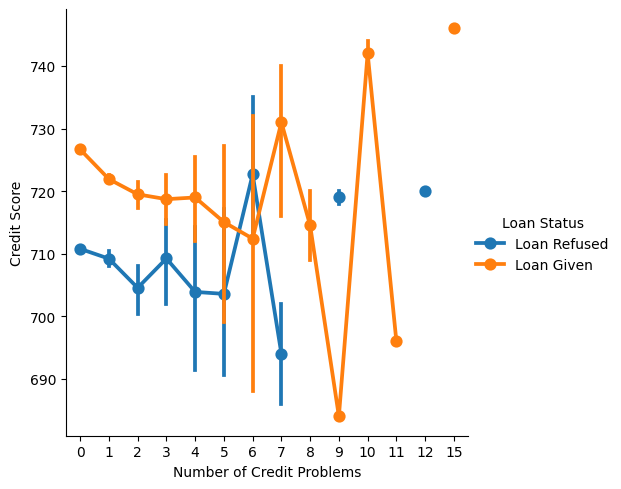

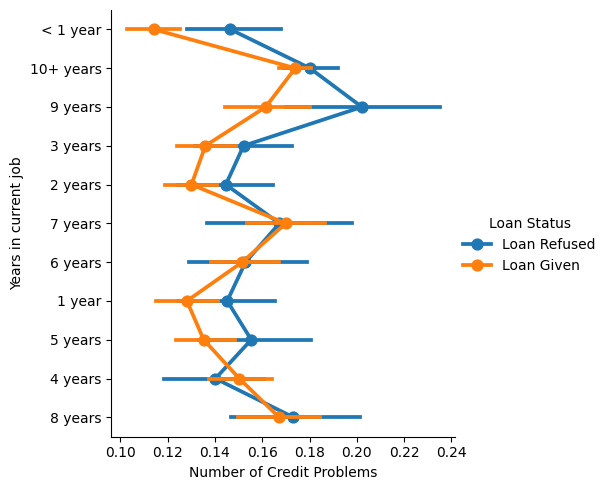

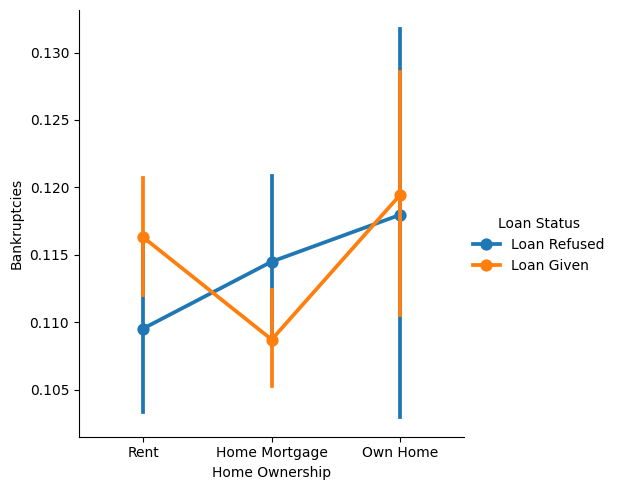

In [ ]:
sns.catplot(y='Credit Score', x='Number of Credit Problems', hue='Loan Status',data=df, kind='point')
sns.catplot(y='Years in current job', x='Number of Credit Problems', hue='Loan Status', data=df, kind='point')
sns.catplot(hue='Loan Status', x='Home Ownership', y='Bankruptcies', data=df, kind='point')
df[df['Number of Credit Problems']>0]['Loan Status'].value_counts()
pd.crosstab(df['Years in current job'], df['Loan Status']).style.background_gradient(cmap='summer_r')

In [ ]:
#pd.qcut(df['Annual Income'],5).value_counts()
df['Annual Income'].quantile([0.2,0.4,0.6,0.8,.97,.99,.999])
#21, 58, 52, 69, 251

,Annual Income
0.200,40764.00
0.400,54645.00
0.600,70462.00
0.800,94600.80
0.970,170949.57
0.990,239286.96
0.999,491575.77


In [ ]:
df['Annual Income'][df['Annual Income']>230000].value_counts()

,count
Annual Income,
245025.0,3
301440.0,2
255600.0,2
238152.0,2
402640.0,2
...,...
270486.0,1
347725.0,1
250475.0,1


In [ ]:
df['Annual Income'].min()

4033.0

In [ ]:
df[df['Annual Income']>239287].value_counts().sum()

np.int64(268)

In [ ]:
#capping
df.loc[df['Annual Income']>239287, 'Annual Income'] = 239287

In [ ]:
df['Annual Income'].isnull().sum()

np.int64(21338)

In [ ]:
df["Purpose"].value_counts()

,count
Purpose,
Debt Consolidation,70447
Home Improvements,5206
other,4917
Other,2850
Business Loan,1328
Buy a Car,1196
Medical Bills,955
Buy House,559
Take a Trip,454


In [ ]:
df['Purpose'] = df['Purpose'].str.replace('Other', 'other', regex=True)

In [ ]:
lens=df[df['Monthly Debt'].str.contains(r'\$',na=False)]['Monthly Debt'].str.len()
print(lens)
#df['Monthly Debt'] = df['Monthly Debt'].str.replace('$', '', regex=True)
df['Monthly Debt'] = df['Monthly Debt'].str.replace(r'[\$,]', '', regex=True)

10       8
55       7
105      6
54811    7
54814    8
54822    6
Name: Monthly Debt, dtype: int64


In [ ]:
df['Monthly Debt'] = pd.to_numeric(df['Monthly Debt'])

<Axes: ylabel='Monthly Debt'>

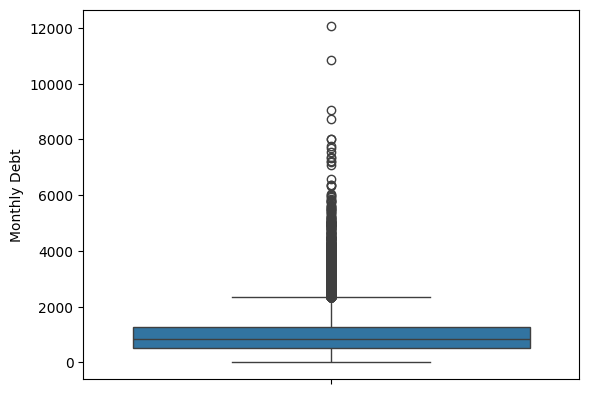

In [ ]:
sns.boxplot(df['Monthly Debt'])

In [ ]:
#df['Monthly Debt'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
#df['Monthly Debt'].quantile([0.9997, 0.99999])
df['Monthly Debt'].quantile([0.999, 1])
#0.999	4927.21625
#1.000	12055.68000

,Monthly Debt
0.999,4927.21625
1.000,12055.68000


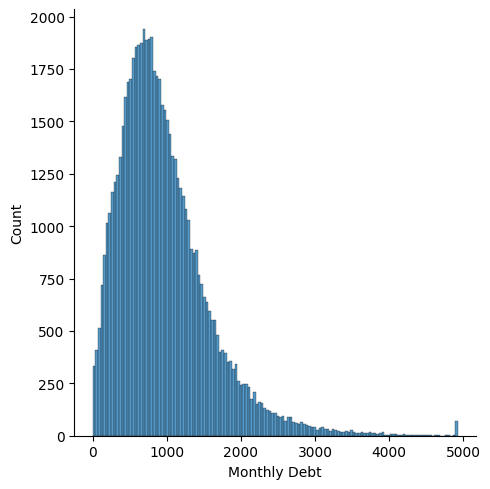

In [ ]:
df.loc[df['Monthly Debt'] > 4927, 'Monthly Debt'] = 4927
sns.displot(df['Monthly Debt'])

In [ ]:
print(df['Months since last delinquent'].describe())
print(df['Months since last delinquent'].isnull().sum())

count    40404.000000
mean        35.080289
std         22.008583
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: Months since last delinquent, dtype: float64
48506


In [ ]:
print(df['Number of Open Accounts'].isnull().sum())
df['Number of Open Accounts'].describe()

0


,Number of Open Accounts
count,88910.000000
mean,11.110348
std,4.978461
min,0.000000
25%,8.000000
50%,10.000000
75%,14.000000
max,76.000000


In [ ]:
df['Number of Open Accounts'].quantile([0.8, 0.999, 1])

,Number of Open Accounts
0.800,15.0
0.999,36.0
1.000,76.0


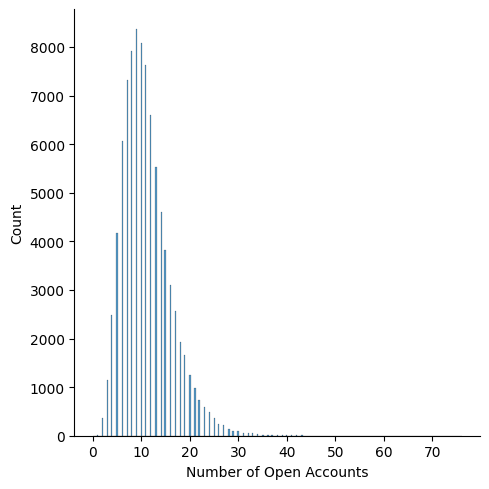

In [ ]:
sns.displot(df['Number of Open Accounts'])

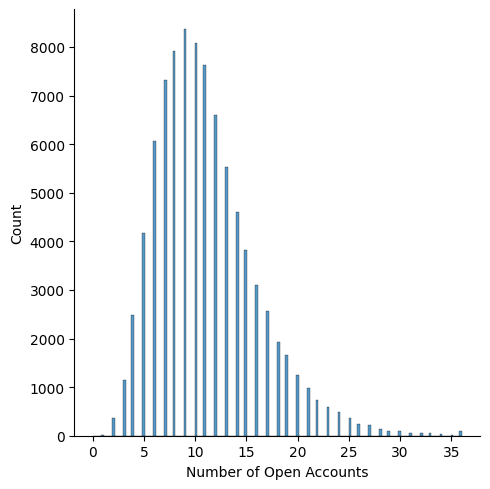

In [ ]:
df.loc[df['Number of Open Accounts'] > 36, 'Number of Open Accounts'] = 36
sns.displot(df['Number of Open Accounts'])

In [ ]:
print(df['Number of Credit Problems'].isnull().sum())

df['Number of Credit Problems'].describe()

0


,Number of Credit Problems
count,88910.000000
mean,0.160477
std,0.473746
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,15.000000


In [ ]:
print(df['Current Credit Balance'].isnull().sum())
df['Current Credit Balance'].describe()

0


,Current Credit Balance
count,8.891000e+04
mean,1.543593e+04
std,1.965873e+04
min,0.000000e+00
25%,5.949000e+03
50%,1.103900e+04
75%,1.930100e+04
max,1.730472e+06


In [ ]:
print(df['Current Credit Balance'].quantile([0.6, 0.75, 0.8, 0.9, 1]))
print(df['Current Credit Balance'].quantile([0.95, 0.96, 0.97, 0.98, 0.99, 1]))
print(df['Current Credit Balance'].quantile([0.98, 0.99, 0.995, 0.999, 1]))
#0.980      57938.120
#0.990      81007.190
#0.995     110219.465
#0.999     227670.033
#1.000    1730472.000

0.60      13693.4
0.75      19301.0
0.80      22034.2
0.90      30843.5
1.00    1730472.0
Name: Current Credit Balance, dtype: float64
0.95      39933.30
0.96      43501.20
0.97      48507.73
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64
0.980      57938.120
0.990      81007.190
0.995     110219.465
0.999     227670.033
1.000    1730472.000
Name: Current Credit Balance, dtype: float64


In [ ]:
df[df['Current Credit Balance']>81007].value_counts().sum()

np.int64(115)

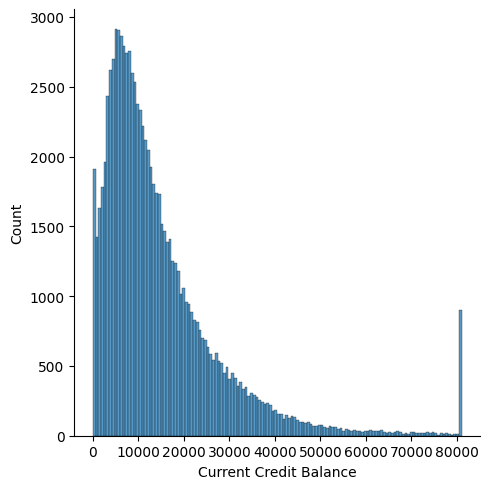

In [ ]:
df.loc[df['Current Credit Balance']>81007, 'Current Credit Balance'] = 81007
sns.displot(df['Current Credit Balance'])

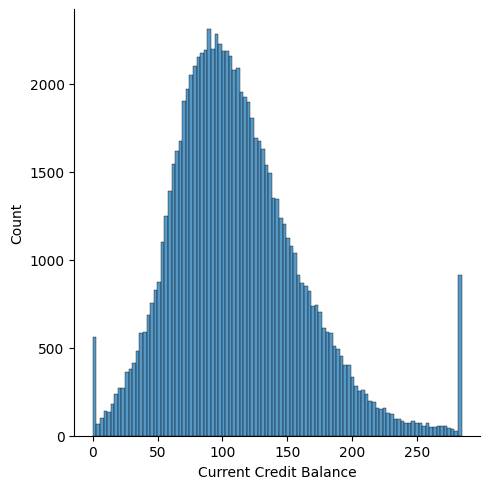

In [ ]:
sns.displot(np.sqrt(df['Current Credit Balance']))

In [ ]:
#sqrt transorm is better than log
df['Current Credit Balance'] = np.sqrt(df['Current Credit Balance'])

In [ ]:
print(df['Maximum Open Credit'].isnull().sum())
df['Maximum Open Credit'].describe()

0


,Maximum Open Credit
count,88910
unique,58216
top,0
freq,450


In [ ]:
df['Maximum Open Credit'].str.isnumeric().all()

np.False_

In [ ]:
df['Maximum Open Credit'].str.contains('#VALUE!').sum()

2

In [ ]:
df['Maximum Open Credit']=df['Maximum Open Credit'].replace('#VALUE!', np.nan, regex=True)
#df.loc[df['Maximum Open Credit'] =="#VALUE!", 'Maximum Open Credit'] = np.nan

In [ ]:
df['Maximum Open Credit'] = pd.to_numeric(df['Maximum Open Credit'], errors='coerce')

In [ ]:
print(df['Maximum Open Credit'].isnull().sum())


2


In [ ]:
print(df['Maximum Open Credit'].mean())
df['Maximum Open Credit'].quantile([0.8, 0.9, 0.95, 0.99, 1])

35965.310174562466


,Maximum Open Credit
0.80,41167.00
0.90,56957.50
0.95,76602.40
0.99,171423.93
1.00,69988086.00


In [ ]:
df['Maximum Open Credit']=df['Maximum Open Credit'].fillna(35965)

In [ ]:
df[df['Maximum Open Credit'] > 171423].value_counts().sum()

np.int64(107)

In [ ]:
df.loc[df['Maximum Open Credit'] > 171423, 'Maximum Open Credit']=171423

In [ ]:
df['Bankruptcies'].describe()

,Bankruptcies
count,88718.000000
mean,0.112672
std,0.343300
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,7.000000


In [ ]:
df['Bankruptcies'].isnull().value_counts()

,count
Bankruptcies,
False,88718
True,192


In [ ]:
df['Bankruptcies'].value_counts()

,count
Bankruptcies,
0.0,79323
1.0,8936
2.0,353
3.0,80
4.0,19
5.0,5
7.0,1
6.0,1


In [ ]:
df['Bankruptcies'].isnull().sum()
df['Bankruptcies'] = df['Bankruptcies'].fillna(3)
df['Bankruptcies'].value_counts()

,count
Bankruptcies,
0.0,79323
1.0,8936
2.0,353
3.0,272
4.0,19
5.0,5
7.0,1
6.0,1


In [ ]:
print(df['Tax Liens'].value_counts())
df['Tax Liens'].isnull().sum()
df['Tax Liens'].isnull().value_counts()

Tax Liens
0.0     87274
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
10.0        1
11.0        1
Name: count, dtype: int64


,count
Tax Liens,
False,88902
True,8


In [ ]:
df['Tax Liens'] = df['Tax Liens'].fillna(5.0)
df['Tax Liens'].isnull().value_counts()

,count
Tax Liens,
False,88910


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88910 entries, 0 to 88909
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       88910 non-null  object 
 1   Customer ID                   88910 non-null  object 
 2   Loan Status                   88910 non-null  object 
 3   Current Loan Amount           76172 non-null  float64
 4   Term                          88910 non-null  object 
 5   Credit Score                  67572 non-null  float64
 6   Years in current job          85093 non-null  object 
 7   Home Ownership                88910 non-null  object 
 8   Annual Income                 67572 non-null  float64
 9   Purpose                       88910 non-null  object 
 10  Monthly Debt                  65536 non-null  float64
 11  Years of Credit History       88910 non-null  float64
 12  Months since last delinquent  40404 non-null  float64
 13  Number

In [ ]:
r=df[['Credit Score','Annual Income','Months since last delinquent']][df['Credit Score'].isnull() & df['Annual Income'].isnull() & df['Months since last delinquent'].isnull()]
print(r)

       Credit Score  Annual Income  Months since last delinquent
17782           NaN            NaN                           NaN
17783           NaN            NaN                           NaN
17786           NaN            NaN                           NaN
17787           NaN            NaN                           NaN
17788           NaN            NaN                           NaN
...             ...            ...                           ...
39112           NaN            NaN                           NaN
39113           NaN            NaN                           NaN
39114           NaN            NaN                           NaN
39118           NaN            NaN                           NaN
39119           NaN            NaN                           NaN

[11619 rows x 3 columns]


In [ ]:
cor=df[['Credit Score','Annual Income','Months since last delinquent']].corr()
print(cor)

                              Credit Score  Annual Income  \
Credit Score                      1.000000       0.016781   
Annual Income                     0.016781       1.000000   
Months since last delinquent      0.044481      -0.084086   

                              Months since last delinquent  
Credit Score                                      0.044481  
Annual Income                                    -0.084086  
Months since last delinquent                      1.000000  


In [ ]:
r=df[['Months since last delinquent','Monthly Debt']][df['Months since last delinquent'].isnull() & df['Monthly Debt'].isnull()]
print(r)

       Months since last delinquent  Monthly Debt
65537                           NaN           NaN
65538                           NaN           NaN
65539                           NaN           NaN
65540                           NaN           NaN
65541                           NaN           NaN
...                             ...           ...
88897                           NaN           NaN
88900                           NaN           NaN
88902                           NaN           NaN
88904                           NaN           NaN
88909                           NaN           NaN

[12709 rows x 2 columns]


In [ ]:
cor=df[['Months since last delinquent','Monthly Debt']].corr()
print(cor)

                              Months since last delinquent  Monthly Debt
Months since last delinquent                      1.000000     -0.058363
Monthly Debt                                     -0.058363      1.000000


In [ ]:
#print(df['Loan Status'][df['Credit Score'].isnull() & df['Annual Income'].isnull() & df['Months since last delinquent'].isnull() & df['Loan Status']].value_counts())

print(df['Loan Status'][df['Credit Score'].isnull() & df['Annual Income'].isnull() & df['Months since last delinquent'].isnull() & (df['Loan Status']=='Loan Given')].value_counts())

print(df['Loan Status'][df['Credit Score'].isnull() & df['Annual Income'].isnull() & df['Months since last delinquent'].isnull() & df['Current Loan Amount'].isnull() & df['Loan Status']=='Loan Given'].value_counts())

Loan Status
Loan Given    8339
Name: count, dtype: int64
Series([], Name: count, dtype: int64)


In [ ]:
df.shape

(88910, 19)

In [ ]:
# remove rows will 2 cols null
#cond_to_remove_cols = (df['Credit Score'].isnull() & df['Annual Income'].isnull())

# remove rows with all 3 cols null
#cond_to_remove_cols = (df['Credit Score'].isnull() & df['Annual Income'].isnull() & df['Months since last delinquent'].isnull())

#remove rows with all 3 cols null and loan given
cond_to_remove_cols = (df['Credit Score'].isnull() & df['Annual Income'].isnull() & df['Months since last delinquent'].isnull() & (df['Loan Status']=='Loan Given'))

df = df[~cond_to_remove_cols]

In [ ]:
df.shape

(80571, 19)

In [ ]:
cat_cols = ['Term', 'Years in current job', 'Home Ownership','Purpose']

for col in cat_cols:
  df[col] = pd.factorize(df[col])[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80571 entries, 0 to 88909
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       80571 non-null  object 
 1   Customer ID                   80571 non-null  object 
 2   Loan Status                   80571 non-null  object 
 3   Current Loan Amount           67833 non-null  float64
 4   Term                          80571 non-null  int64  
 5   Credit Score                  67572 non-null  float64
 6   Years in current job          80571 non-null  int64  
 7   Home Ownership                80571 non-null  int64  
 8   Annual Income                 67572 non-null  float64
 9   Purpose                       80571 non-null  int64  
 10  Monthly Debt                  57197 non-null  float64
 11  Years of Credit History       80571 non-null  float64
 12  Months since last delinquent  40404 non-null  float64
 13  Number

/tmp/ipython-input-537-1935787279.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.factorize(df[col])[0]
/tmp/ipython-input-537-1935787279.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.factorize(df[col])[0]
/tmp/ipython-input-537-1935787279.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [ ]:
df.isnull().sum()

,0
Loan ID,0
Customer ID,0
Loan Status,0
Current Loan Amount,12738
Term,0
Credit Score,12999
Years in current job,0
Home Ownership,0
Annual Income,12999
Purpose,0


In [ ]:
df['Home Ownership'].value_counts()

,count
Home Ownership,
1,39384
0,33869
2,7318


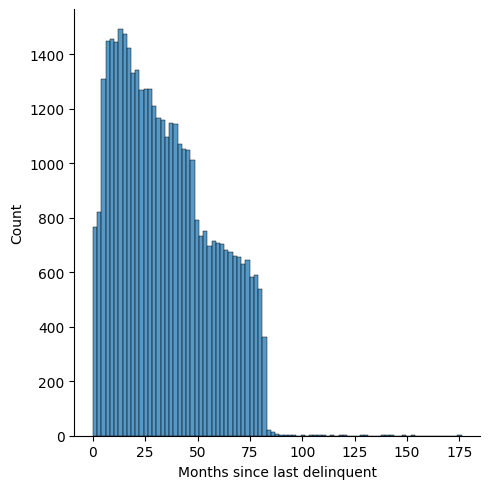

In [ ]:
#sns.displot(df['Months since last delinquent'])
sns.displot(df['Months since last delinquent'])

In [ ]:
len(df)

80571

In [ ]:
#Binarize the target variable
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
df['Loan Status'] = df['Loan Status'].astype(str)
y = lb.fit_transform(df['Loan Status'])
y = y.ravel()
#np.bincount(y)

/tmp/ipython-input-542-1803938556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Loan Status'] = df['Loan Status'].astype(str)


In [ ]:
y

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80571 entries, 0 to 88909
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       80571 non-null  object 
 1   Customer ID                   80571 non-null  object 
 2   Loan Status                   80571 non-null  object 
 3   Current Loan Amount           67833 non-null  float64
 4   Term                          80571 non-null  int64  
 5   Credit Score                  67572 non-null  float64
 6   Years in current job          80571 non-null  int64  
 7   Home Ownership                80571 non-null  int64  
 8   Annual Income                 67572 non-null  float64
 9   Purpose                       80571 non-null  int64  
 10  Monthly Debt                  57197 non-null  float64
 11  Years of Credit History       80571 non-null  float64
 12  Months since last delinquent  40404 non-null  float64
 13  Number

In [ ]:
cols = df.columns[3:19]
X_scaled = preprocessing.scale(df[cols])
X_scaled = pd.DataFrame(X_scaled, columns=cols)

In [ ]:
X_scaled.isnull().sum()

,0
Current Loan Amount,12738
Term,0
Credit Score,12999
Years in current job,0
Home Ownership,0
Annual Income,12999
Purpose,0
Monthly Debt,23374
Years of Credit History,0
Months since last delinquent,40167


<Axes: ylabel='Frequency'>

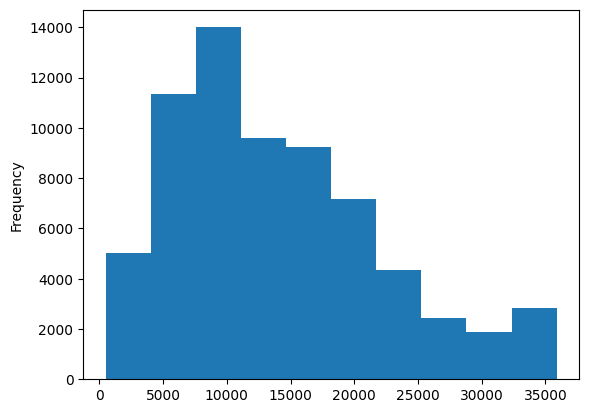

In [ ]:
df['Current Loan Amount'].plot(kind='hist')

In [ ]:
'''from sklearn.impute import KNNImputer

# Create KNN imputer instance (you can tune n_neighbors)
imputer = KNNImputer(n_neighbors=11)
_2cols = ['Months since last delinquent']
# Apply imputation
df_2cols = imputer.fit_transform(X_scaled[_2cols])
df_2cols = pd.DataFrame(df_2cols, columns=_2cols)'''


"from sklearn.impute import KNNImputer\n\n# Create KNN imputer instance (you can tune n_neighbors)\nimputer = KNNImputer(n_neighbors=11)\n_2cols = ['Months since last delinquent']\n# Apply imputation\ndf_2cols = imputer.fit_transform(X_scaled[_2cols])\ndf_2cols = pd.DataFrame(df_2cols, columns=_2cols)"

In [ ]:
corr_matrix = df[df.columns[3:19]].corr()
print(corr_matrix['Current Loan Amount'].sort_values(ascending=False))
print(corr_matrix['Annual Income'].sort_values(ascending=False))
print(corr_matrix['Monthly Debt'].sort_values(ascending=False))

Current Loan Amount             1.000000
Annual Income                   0.477472
Monthly Debt                    0.442800
Current Credit Balance          0.439809
Term                            0.414419
Maximum Open Credit             0.352105
Number of Open Accounts         0.199803
Years of Credit History         0.148229
Home Ownership                  0.122656
Tax Liens                       0.022246
Years in current job           -0.024236
Months since last delinquent   -0.039258
Number of Credit Problems      -0.069360
Bankruptcies                   -0.101680
Purpose                        -0.149549
Credit Score                   -0.226565
Name: Current Loan Amount, dtype: float64
Annual Income                   1.000000
Monthly Debt                    0.610933
Current Loan Amount             0.477472
Current Credit Balance          0.393230
Maximum Open Credit             0.388785
Years of Credit History         0.211644
Number of Open Accounts         0.198767
Home Ownership 

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

_cols = ['Current Loan Amount','Annual Income','Monthly Debt','Current Credit Balance','Term','Maximum Open Credit']
imputer = IterativeImputer()
df_col = imputer.fit_transform(X_scaled[_cols])
df_col = pd.DataFrame(df_col, columns=_cols)
X_scaled[_cols]=df_col

In [ ]:
X_scaled.isnull().sum()

,0
Current Loan Amount,0
Term,0
Credit Score,12999
Years in current job,0
Home Ownership,0
Annual Income,0
Purpose,0
Monthly Debt,0
Years of Credit History,0
Months since last delinquent,40167


In [ ]:
'''updated_df = X_scaled.copy()
updated_df[['Months since last delinquent']] = df_2cols
updated_df[['Monthly Debt']] = df_col
updated_df.isnull().sum()'''

"updated_df = X_scaled.copy()\nupdated_df[['Months since last delinquent']] = df_2cols\nupdated_df[['Monthly Debt']] = df_col\nupdated_df.isnull().sum()"

In [ ]:
updated_df = X_scaled.copy()

In [ ]:
!pip install fancyimpute
from fancyimpute import KNN, SoftImpute

In [ ]:
updated_df = pd.DataFrame(data=SoftImpute().fit_transform(df[df.columns[3:19]]), columns = df[df.columns[3:19]].columns, index=df.index)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[SoftImpute] Max Singular Value of X_init = 22945501.408902
[SoftImpute] Iter 1: observed MAE=264.756498 rank=3
[SoftImpute] Iter 2: observed MAE=261.689521 rank=3
[SoftImpute] Iter 3: observed MAE=261.844032 rank=3
[SoftImpute] Iter 4: observed MAE=262.390513 rank=3
[SoftImpute] Iter 5: observed MAE=262.898886 rank=3
[SoftImpute] Iter 6: observed MAE=263.305728 rank=3
[SoftImpute] Iter 7: observed MAE=263.613699 rank=3
[SoftImpute] Iter 8: observed MAE=263.839256 rank=3
[SoftImpute] Iter 9: observed MAE=263.999537 rank=3
[SoftImpute] Iter 10: observed MAE=264.111042 rank=3
[SoftImpute] Iter 11: observed MAE=264.187464 rank=3
[SoftImpute] Iter 12: observed MAE=264.238915 rank=3
[SoftImpute] Iter 13: observed MAE=264.272705 rank=3
[SoftImpute] Iter 14: observed MAE=264.294302 rank=3
[SoftImpute] Iter 15: observed MAE=264.307876 rank=3
[SoftImpute] Iter 16: observed MAE=264.316175 rank=3
[SoftImpute] Iter 17: observed MAE=264.321719 rank=3
[SoftImpute] Iter 18: observed MAE=264.325564 ra

In [ ]:
#df_LC = pd.get_dummies(updated_df, drop_first=True)
#df_LC.info()

In [ ]:
'''#Binarize the target variable
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
df['Loan Status'] = df['Loan Status'].astype(str)
y = lb.fit_transform(df['Loan Status'])
y = y.ravel()
#np.bincount(y)'''

"#Binarize the target variable\nfrom sklearn import preprocessing\nlb = preprocessing.LabelBinarizer()\ndf['Loan Status'] = df['Loan Status'].astype(str)\ny = lb.fit_transform(df['Loan Status'])\ny = y.ravel()\n#np.bincount(y)"

In [ ]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80571 entries, 0 to 88909
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Current Loan Amount           80571 non-null  float64
 1   Term                          80571 non-null  float64
 2   Credit Score                  80571 non-null  float64
 3   Years in current job          80571 non-null  float64
 4   Home Ownership                80571 non-null  float64
 5   Annual Income                 80571 non-null  float64
 6   Purpose                       80571 non-null  float64
 7   Monthly Debt                  80571 non-null  float64
 8   Years of Credit History       80571 non-null  float64
 9   Months since last delinquent  80571 non-null  float64
 10  Number of Open Accounts       80571 non-null  float64
 11  Number of Credit Problems     80571 non-null  float64
 12  Current Credit Balance        80571 non-null  float64
 13  Maximu

In [ ]:
'''#Scaling independent variables
X_scaled = preprocessing.scale(df_LC)
type(X_scaled)'''

'#Scaling independent variables\nX_scaled = preprocessing.scale(df_LC)\ntype(X_scaled)'

In [ ]:

def feat_importance(estimator):
  feature_importance = {}
  for index, name in enumerate(updated_df.columns):#_LC.columns):
    feature_importance[name] = estimator.feature_importances_[index]
  feature_importance = {k: v for k, v in feature_importance.items()}
  sorted_x = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse=True)
  return sorted_x

In [ ]:
def classify(est, x, y, X_test, y_test):
  est.fit(x,y)
  y1 = est.predict(X_test)
  y2 = est.predict_proba(X_test)
  return est, y1, y2[:,1]

In [ ]:

def plot_roc_curve(model, yy_test, p_prob):
  fpr2, tpr2, thresh2 = roc_curve(yy_test, p_prob, pos_label=1)

  print(f" Area UC: {metrics.auc(fpr2, tpr2)}")
  plt.plot(fpr2, tpr2, linestyle='--',color='red', label=model.__class__.__name__)

  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()

In [ ]:
def print_metrics(model, y_test, y_pred):
  print(f"Accuracy: {accuracy_score(y_test, y_pred)} \n Precision: {precision_score(y_test, y_pred)} \n Recall: {recall_score(y_test, y_pred)} \n f1-score: {f1_score(y_test, y_pred)} \n")
  print(f"Confusion matrix: {confusion_matrix(y_test, y_pred)}")
  print(f"Classification report: {classification_report(y_test, y_pred)}")
  print(f"Mathews Correlation: {matthews_corrcoef(y_test, y_pred)}")

In [ ]:
#Current Loan Amount, Term, Credit Score, Annual Income, Monthly Debt, Number of Open Accounts, Current Credit Balance, Maximum Open Account, Bankruptcies, Tax Liens

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(updated_df, y, test_size=0.2, stratify=y, random_state=3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(64456, 16) (16115, 16) (64456,) (16115,)


[0.06567619 0.16963856 0.20872475 0.03678486 0.06495041 0.06561226
 0.04044336 0.0364802  0.0379499  0.06053732 0.03280087 0.03317539
 0.03863845 0.0391628  0.038924   0.03050071]


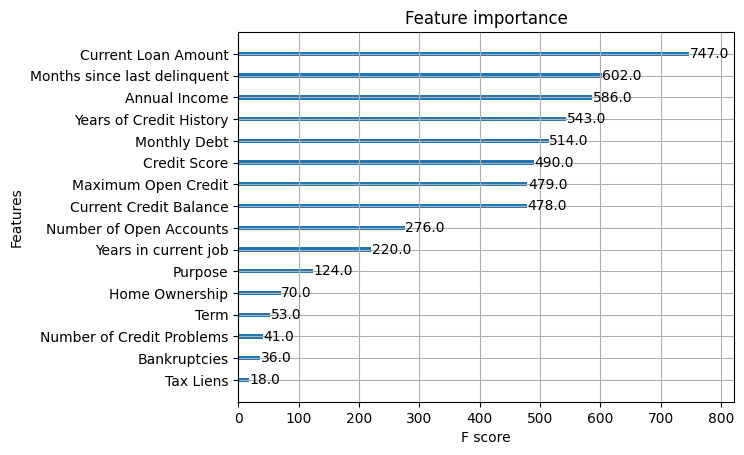

In [ ]:
feature_names=updated_df.columns
# Finding importance of features
xgb, y_pred, y_prob = classify(XGBClassifier(), X_train, y_train, X_test, y_test)

print(xgb.feature_importances_)
plot_importance(xgb)
pyplot.show()
#feat1 = feat_importance(xgb)
#xgb.get_booster().get_score(importance_type='weight')

Accuracy: 0.7287620229599752 
 Precision: 0.6120107962213225 
 Recall: 0.3602780536246276 
 f1-score: 0.45355669458682335 

Confusion matrix: [[9930 1150]
 [3221 1814]]
Classification report:               precision    recall  f1-score   support

           0       0.76      0.90      0.82     11080
           1       0.61      0.36      0.45      5035

    accuracy                           0.73     16115
   macro avg       0.68      0.63      0.64     16115
weighted avg       0.71      0.73      0.71     16115

Mathews Correlation: 0.3068437147630159
 Area UC: 0.7335637720074999


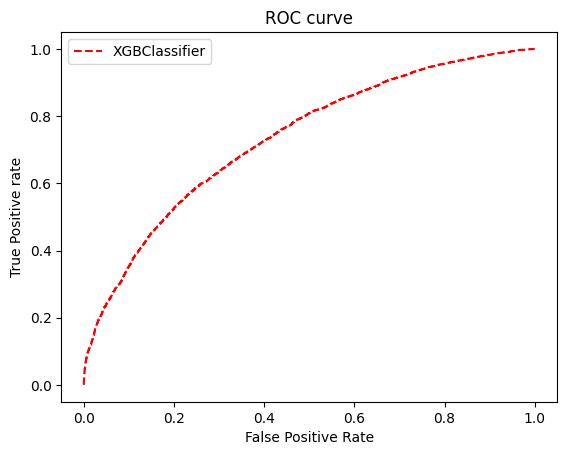

In [ ]:
xgb, y_pred, y_prob = classify(XGBClassifier(n_estimators=360, learning_rate=0.01, max_depth=27, min_child_weight=2), X_train, y_train, X_test, y_test)

print_metrics(xgb, y_test, y_pred)
plot_roc_curve(xgb, y_test, y_prob)

 xgb - before oversampling - after removing credit score and annual income null for loan given
 * Accuracy: 0.730251318647223
 * Precision: 0.6027479091995221
 * Recall: 0.40079443892750743
 * f1-score: 0.48145055469402365
 * Mathews Correlation: 0.32074886363622557
 * Area UC: 0.7711192321618705

xgb - Before oversampling, After removing all credit score & annual income nulls for loan given & current loan amount 99999999 to null, Iterative imputing with ['Current Loan Amount','Annual Income','Monthly Debt','Current Credit Balance','Term','Maximum Open Credit']
* Accuracy: 0.7287620229599752
* Precision: 0.6120107962213225
* Recall: 0.3602780536246276
* f1-score: 0.45355669458682335
* Mathews Correlation: 0.3068437147630159
* Area UC: 0.7335637720074999

Accuracy: 0.6835867204467887 
 Precision: 0.4870967741935484 
 Recall: 0.23992055610724924 
 f1-score: 0.3214903526280772 

Confusion matrix: [[9808 1272]
 [3827 1208]]
Classification report:               precision    recall  f1-score   support

           0       0.72      0.89      0.79     11080
           1       0.49      0.24      0.32      5035

    accuracy                           0.68     16115
   macro avg       0.60      0.56      0.56     16115
weighted avg       0.65      0.68      0.65     16115

Mathews Correlation: 0.1607088745586704
 Area UC: 0.6703941184273264


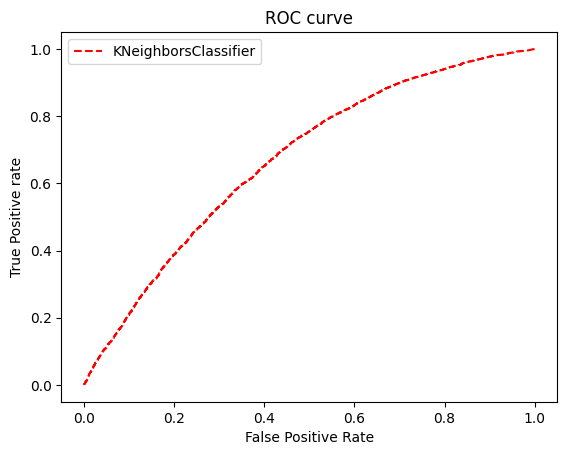

In [ ]:
knn, y_pred, y_prob = classify(KNeighborsClassifier(n_neighbors=25, weights='distance', algorithm='auto', metric='euclidean'), X_train, y_train, X_test, y_test)

print_metrics(knn, y_test, y_pred)
plot_roc_curve(knn, y_test, y_prob)

Accuracy: 0.6120384734719205 
 Precision: 0.4051737572074178 
 Recall: 0.5163853028798411 
 f1-score: 0.4540691582256374 

Confusion matrix: [[7263 3817]
 [2435 2600]]
Classification report:               precision    recall  f1-score   support

           0       0.75      0.66      0.70     11080
           1       0.41      0.52      0.45      5035

    accuracy                           0.61     16115
   macro avg       0.58      0.59      0.58     16115
weighted avg       0.64      0.61      0.62     16115

Mathews Correlation: 0.16274772779765156
 Area UC: 0.6030235463667684


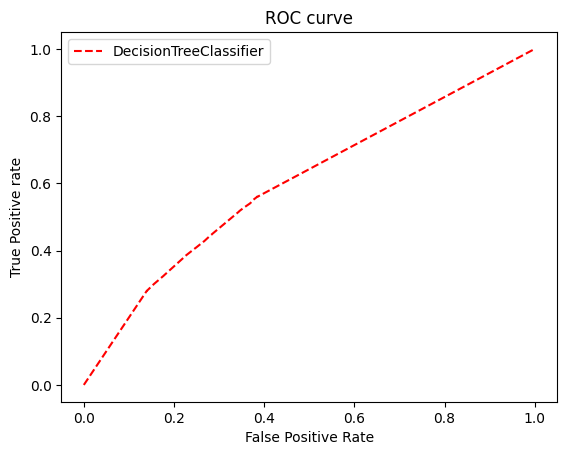

In [ ]:
dt, y_pred, y_prob = classify(DecisionTreeClassifier(max_depth=180, min_samples_split=3, min_samples_leaf=3, max_features='log2', criterion='log_loss',class_weight='balanced',random_state=3), X_train, y_train, X_test, y_test)

print_metrics(dt, y_test, y_pred)
plot_roc_curve(dt, y_test, y_prob)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Accuracy: 0.6574619919329817 
 Precision: 0.4623622536085674 
 Recall: 0.5916583912611718 
 f1-score: 0.5190799790904339 

Confusion matrix: [[7616 3464]
 [2056 2979]]
Classification report:               precision    recall  f1-score   support

           0       0.79      0.69      0.73     11080
           1       0.46      0.59      0.52      5035

    accuracy                           0.66     16115
   macro avg       0.62      0.64      0.63     16115
weighted avg       0.69      0.66      0.67     16115

Mathews Correlation: 0.26400213003632894
 Area UC: 0.6632752322192307


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


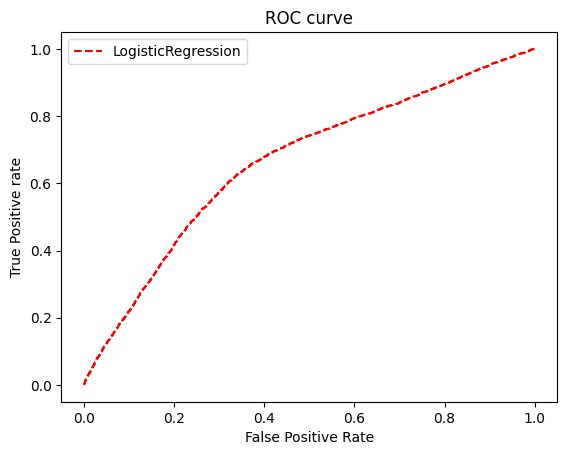

In [ ]:
lr, y_pred, y_prob = classify(LogisticRegression(solver='saga', class_weight='balanced', penalty='l2', l1_ratio=.2, fit_intercept=False, random_state=3), X_train, y_train, X_test, y_test)

print_metrics(lr, y_test, y_pred)
plot_roc_curve(lr, y_test, y_prob)

Accuracy: 0.7281414830902886 
 Precision: 0.5718365553602812 
 Recall: 0.5169811320754717 
 f1-score: 0.5430270157504955 

Confusion matrix: [[9131 1949]
 [2432 2603]]
Classification report:               precision    recall  f1-score   support

           0       0.79      0.82      0.81     11080
           1       0.57      0.52      0.54      5035

    accuracy                           0.73     16115
   macro avg       0.68      0.67      0.67     16115
weighted avg       0.72      0.73      0.72     16115

Mathews Correlation: 0.35114598429589267
 Area UC: 0.7457901010615224


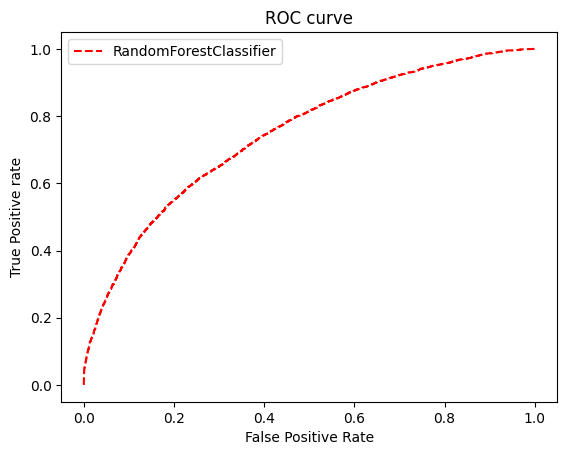

In [ ]:
rf, y_pred, y_prob = classify(RandomForestClassifier(n_estimators=256,criterion='log_loss', min_samples_split=9, min_samples_leaf=7, max_features='sqrt',max_depth=64, class_weight='balanced',random_state=3), X_train, y_train, X_test, y_test)

print_metrics(rf, y_test, y_pred)
plot_roc_curve(rf, y_test, y_prob)

random forest - Before oversampling, After removing all credit score & annual income nulls:
 * Accuracy: 0.7196448390677026
 * Precision: 0.5041322314049587
 * Recall: 0.5899111343439624
 * f1-score: 0.543658918463206
 * Mathews Correlation: 0.34532745279760185
 * Area UC: 0.7779471085521884

random forest - Before oversampling, After removing all credit score & annual income null for loan given:
* Accuracy: 0.7265280794291034
* Precision: 0.5574880995972171
* Recall: 0.6047666335650447
* f1-score: 0.5801657616461846
* Mathews Correlation: 0.37857216789430725
* Area UC: 0.7836732583109569

random forest - Before oversampling, After removing all credit score & annual income null for loan given & current loan amount 99999999 to null
* Accuracy: 0.7281414830902886
* Precision: 0.5718365553602812
* Recall: 0.5169811320754717
* f1-score: 0.5430270157504955
* Mathews Correlation: 0.35114598429589267
* Area UC: 0.7457901010615224

In [ ]:
'''from sklearn.model_selection import cross_val_score, KFold
knn = KNeighborsClassifier(n_neighbors=25)
# YOUR CODE HERE : call kfold cross validation
kf=KFold(n_splits=7)
score = cross_val_score(knn,X_train, y_train, cv=kf) # YOUR CODE HERE : Compute the Cross Validation score using the imported function "cross_val_score"
print(score)
print(np.mean(score))'''

'from sklearn.model_selection import cross_val_score, KFold\nknn = KNeighborsClassifier(n_neighbors=25)\n# YOUR CODE HERE : call kfold cross validation\nkf=KFold(n_splits=7)\nscore = cross_val_score(knn,X_train, y_train, cv=kf) # YOUR CODE HERE : Compute the Cross Validation score using the imported function "cross_val_score"\nprint(score)\nprint(np.mean(score))'

In [ ]:
'''
from sklearn.model_selection import GridSearchCV

k_range = list(range(1, 31))
print(k_range)

# Mention all the parameters that we want to iterate across
param_grid = dict(n_neighbors=k_range) # YOUR CODE HERE
print(param_grid)

grid = GridSearchCV(knn, param_grid, scoring='accuracy', cv=10, return_train_score=False)
grid.fit(X_train, y_train)

grid_mean_score = grid.cv_results_['mean_test_score']
print(grid_mean_score)

plt.plot(k_range,grid_mean_score)
plt.xlabel('k for Knn')
plt.ylabel('accuracy - cv')
'''

"\nfrom sklearn.model_selection import GridSearchCV\n\nk_range = list(range(1, 31))\nprint(k_range)\n\n# Mention all the parameters that we want to iterate across\nparam_grid = dict(n_neighbors=k_range) # YOUR CODE HERE\nprint(param_grid)\n\ngrid = GridSearchCV(knn, param_grid, scoring='accuracy', cv=10, return_train_score=False)\ngrid.fit(X_train, y_train)\n\ngrid_mean_score = grid.cv_results_['mean_test_score']\nprint(grid_mean_score)\n\nplt.plot(k_range,grid_mean_score)\nplt.xlabel('k for Knn')\nplt.ylabel('accuracy - cv')\n"

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}
[0.70921637 0.76059042 0.73040922 0.76059042 0.7451098  0.76335053
 0.75454218 0.76539062 0.76020641 0.76797072 0.76432257 0.76895476
 0.76555862 0.76960278 0.76763471 0.77062282 0.76920677 0.77130685
 0.7699748  0.77101884 0.77043082 0.77149886 0.77081483 0.77190688
 0.77140286 0.77193088 0.77167887 0.7724349  0.77232689 0.7724709 ]
Text(0, 0.5, 'accuracy - cv')

Best Estimator, Best parameters & Best sore:  KNeighborsClassifier(n_neighbors=30) {'n_neighbors': 30} 0.7724708988359535

In [ ]:
'''# YOUR CODE HERE : print the best score, params, estimator
print("Best Estimator, Best parameters & Best sore: ",grid.best_estimator_, grid.best_params_, grid.best_score_)'''

'# YOUR CODE HERE : print the best score, params, estimator\nprint("Best Estimator, Best parameters & Best sore: ",grid.best_estimator_, grid.best_params_, grid.best_score_)'

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(64456, 16) (64456,) (16115, 16) (16115,)


In [ ]:
updated_df.columns.tolist()

['Current Loan Amount',
 'Term',
 'Credit Score',
 'Years in current job',
 'Home Ownership',
 'Annual Income',
 'Purpose',
 'Monthly Debt',
 'Years of Credit History',
 'Months since last delinquent',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Current Credit Balance',
 'Maximum Open Credit',
 'Bankruptcies',
 'Tax Liens']

In [ ]:
#index_split = int(0.95*len(X_scaled))
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(updated_df, y, test_size=0.05, stratify=y, random_state=3)

print(X_train_smote.shape, y_train_smote.shape, X_test_smote.shape, y_test_smote.shape)

(76542, 16) (76542,) (4029, 16) (4029,)


In [ ]:
print(np.unique(y_train_smote, return_counts=True))
print(np.unique(y_test_smote, return_counts=True))

(array([0, 1]), array([52628, 23914]))
(array([0, 1]), array([2770, 1259]))


In [ ]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote)

print(X_train_smote.shape, y_train_smote.shape, X_test_smote.shape, y_test_smote.shape)

(105256, 16) (105256,) (4029, 16) (4029,)


In [ ]:
print(np.unique(y_train_smote, return_counts=True))
print(np.unique(y_test_smote, return_counts=True))

(array([0, 1]), array([52628, 52628]))
(array([0, 1]), array([2770, 1259]))


In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([44318, 20138]))
(array([0, 1]), array([11080,  5035]))


Accuracy: 0.6130553487217671 
 Precision: 0.4185667752442997 
 Recall: 0.6123907863383637 
 f1-score: 0.49725894872621734 

Confusion matrix: [[1699 1071]
 [ 488  771]]
Classification report:               precision    recall  f1-score   support

           0       0.78      0.61      0.69      2770
           1       0.42      0.61      0.50      1259

    accuracy                           0.61      4029
   macro avg       0.60      0.61      0.59      4029
weighted avg       0.66      0.61      0.63      4029

Mathews Correlation: 0.21004280838417388
 Area UC: 0.6513581634613455


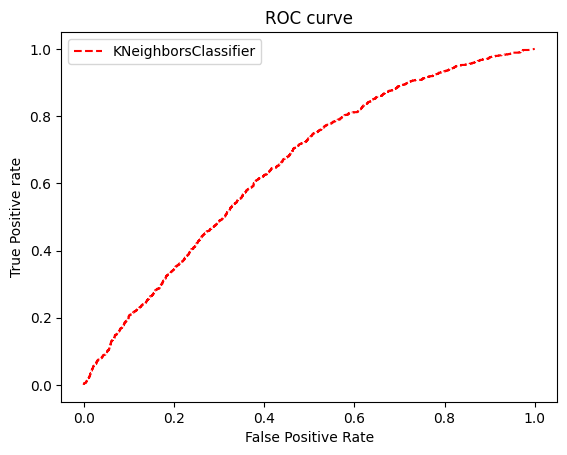

In [ ]:
knn, y_pred, y_prob = classify(KNeighborsClassifier(n_neighbors=25, weights='distance', algorithm='auto', metric='euclidean'), X_train_smote, y_train_smote, X_test_smote, y_test_smote)

print_metrics(knn, y_test_smote, y_pred)
plot_roc_curve(knn, y_test_smote, y_prob)

Accuracy: 0.6356415984115165 
 Precision: 0.4212509419743783 
 Recall: 0.44400317712470216 
 f1-score: 0.4323279195668987 

Confusion matrix: [[2002  768]
 [ 700  559]]
Classification report:               precision    recall  f1-score   support

           0       0.74      0.72      0.73      2770
           1       0.42      0.44      0.43      1259

    accuracy                           0.64      4029
   macro avg       0.58      0.58      0.58      4029
weighted avg       0.64      0.64      0.64      4029

Mathews Correlation: 0.16444939452877738
 Area UC: 0.6004339872054779


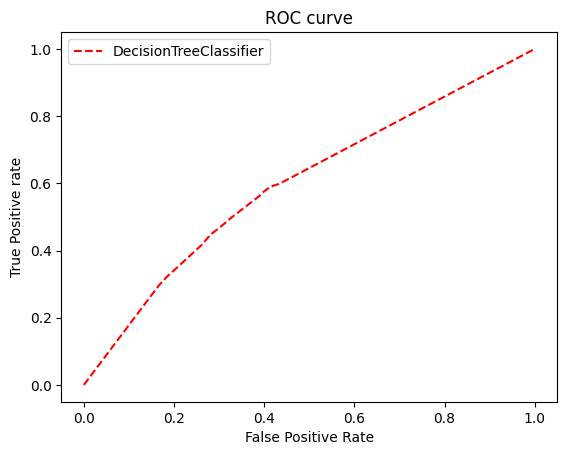

In [ ]:
dt, y_pred, y_prob = classify(DecisionTreeClassifier(max_depth=60, min_samples_split=3, min_samples_leaf=3, max_features='log2', criterion='log_loss',class_weight='balanced',random_state=3), X_train_smote, y_train_smote, X_test_smote, y_test_smote)

print_metrics(dt, y_test_smote, y_pred)
plot_roc_curve(dt, y_test_smote, y_prob)

Accuracy: 0.6562422437329362 
 Precision: 0.4609181141439206 
 Recall: 0.5901509134233519 
 f1-score: 0.5175896900034831 

Confusion matrix: [[1901  869]
 [ 516  743]]
Classification report:               precision    recall  f1-score   support

           0       0.79      0.69      0.73      2770
           1       0.46      0.59      0.52      1259

    accuracy                           0.66      4029
   macro avg       0.62      0.64      0.63      4029
weighted avg       0.68      0.66      0.67      4029

Mathews Correlation: 0.2615296966285012
 Area UC: 0.6618713493890916


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


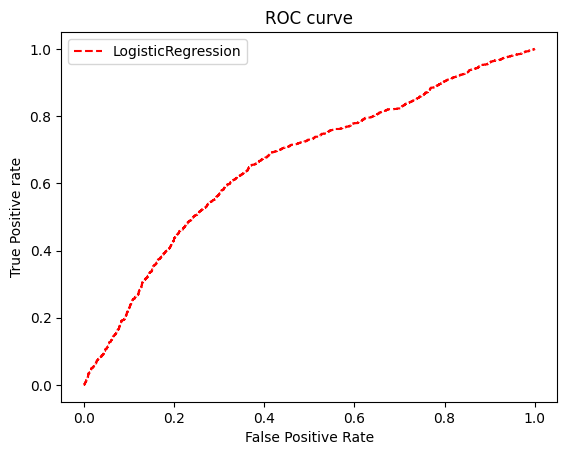

In [ ]:
lr, y_pred, y_prob = classify(LogisticRegression(solver='saga', class_weight='balanced', penalty='elasticnet', l1_ratio=.9,fit_intercept=False, random_state=3), X_train_smote, y_train_smote, X_test_smote, y_test_smote)

print_metrics(lr, y_test_smote, y_pred)
plot_roc_curve(lr, y_test_smote, y_prob)

Accuracy: 0.7379002233804914 
 Precision: 0.6154721274175199 
 Recall: 0.42970611596505165 
 f1-score: 0.5060804490177736 

Confusion matrix: [[2432  338]
 [ 718  541]]
Classification report:               precision    recall  f1-score   support

           0       0.77      0.88      0.82      2770
           1       0.62      0.43      0.51      1259

    accuracy                           0.74      4029
   macro avg       0.69      0.65      0.66      4029
weighted avg       0.72      0.74      0.72      4029

Mathews Correlation: 0.3453095509760282
 Area UC: 0.7341690012416019


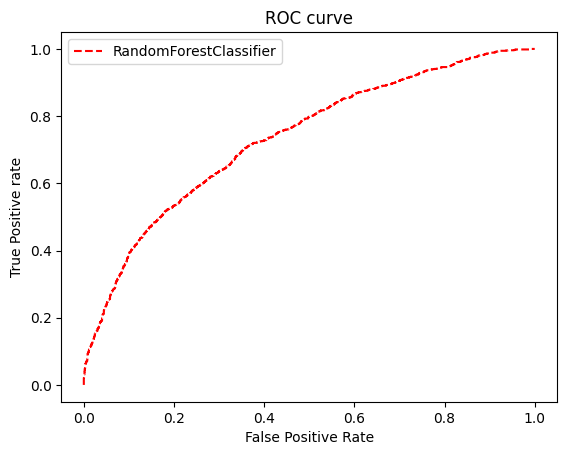

In [ ]:
rf, y_pred, y_prob = classify(RandomForestClassifier(n_estimators=256,criterion='log_loss', min_samples_split=9, min_samples_leaf=7, max_features='sqrt',max_depth=31, class_weight='balanced',random_state=3), X_train_smote, y_train_smote, X_test_smote, y_test_smote)

print_metrics(rf, y_test_smote, y_pred)
plot_roc_curve(rf, y_test_smote, y_prob)

#RandomForestClassifier(n_estimators=164,criterion='log_loss', #min_samples_split=3, min_samples_leaf=2, max_features='sqrt',max_depth=31, #class_weight='balanced',random_state=3)

random forest - After oversampling, After removing all credit score & annual income nulls:
*  Accuracy: 0.7372003551346552
*  Precision: 0.54521625163827
*  Recall: 0.4346917450365726
*  f1-score: 0.48372093023255813
*  Mathews Correlation: 0.31403916720771263
*  Area UC: 0.7820919695545966

random forest - After oversampling, After removing all credit score & annual income nulls for loan given:
* Accuracy: 0.741126830479027
* Precision: 0.6067193675889329
* Recall: 0.48768864177918986
* f1-score: 0.5407309555261999
* Mathews Correlation: 0.36765567495757817
* Area UC: 0.7795029577654604

random forest - After oversampling, After removing all credit score & annual income nulls for loan given & current loan amount 99999999 to null
* Accuracy: 0.7359146190121618
* Precision: 0.6121979286536249
* Recall: 0.42255758538522636
* f1-score: 0.5
* Mathews Correlation: 0.33909164159796096
* Area UC: 0.7344697958095217

random forest - After oversampling, After removing all credit score & annual income nulls for loan given & current loan amount 99999999 to null, Iterative imputing with ['Current Loan Amount','Annual Income','Monthly Debt','Current Credit Balance','Term','Maximum Open Credit']

* Accuracy: 0.7379002233804914
* Precision: 0.6154721274175199
* Recall: 0.42970611596505165
* f1-score: 0.5060804490177736
* Mathews Correlation: 0.3453095509760282
* Area UC: 0.7341690012416019

Accuracy: 0.7163067758749069 
 Precision: 0.5471544715447154 
 Recall: 0.534551231135822 
 f1-score: 0.5407794294897549 

Confusion matrix: [[2213  557]
 [ 586  673]]
Classification report:               precision    recall  f1-score   support

           0       0.79      0.80      0.79      2770
           1       0.55      0.53      0.54      1259

    accuracy                           0.72      4029
   macro avg       0.67      0.67      0.67      4029
weighted avg       0.71      0.72      0.72      4029

Mathews Correlation: 0.33562412295612676
 Area UC: 0.7341690012416019


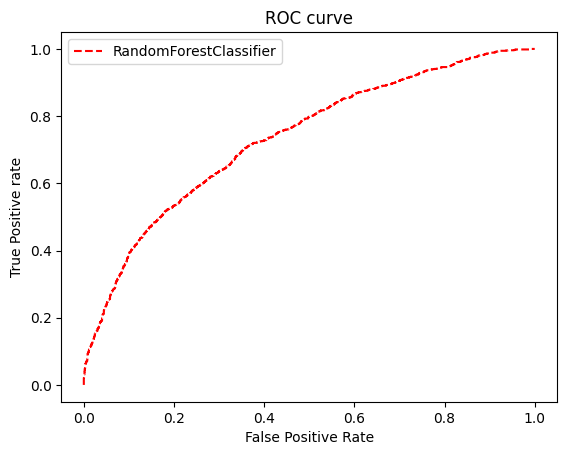

In [ ]:
y_pred_thresh = (y_prob > 0.43).astype(int)
print_metrics(rf, y_test_smote, y_pred_thresh)
plot_roc_curve(rf, y_test_smote, y_prob)

--- Randomized Search Results for RandomForestClassifier ---
Best Hyperparameters found: {'criterion': 'gini', 'max_depth': 28, 'max_features': 1.0, 'min_samples_leaf': 8, 'min_samples_split': 15, 'n_estimators': 341}
Best Cross-Validation ROC AUC Score (refit metric): 0.6375100892894904

--- Evaluation on Test Data (using Best RandomForestClassifier Model) ---
Test Accuracy: 0.7685
Test F1-Score: 0.0374
Test Precision: 0.3333
Test Recall: 0.0198
Test ROC AUC: 0.6847
Test Matthews Corr Coeff: 0.0297

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.99      0.87       344
           1       0.33      0.02      0.04       101

    accuracy                           0.77       445
   macro avg       0.55      0.50      0.45       445
weighted avg       0.67      0.77      0.68       445


Confusion Matrix:
 [[340   4]
 [ 99   2]]`


Training data shape: (88885, 16), (88885,)
Test data shape: (22222, 16), (22222,)

--- Starting Randomized Search Cross-Validation for Logistic Regression (with MCC) ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Randomized Search Results for Logistic Regression ---
Best Hyperparameters found: {'C': np.float64(0.14445251022763064), 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation ROC AUC Score (refit metric): 0.6261794627640074

--- Evaluation on Test Data (using Best Logistic Regression Model) ---
Test Accuracy: 0.7734
Test F1-Score: 0.0032
Test Precision: 0.5000
Test Recall: 0.0016
Test ROC AUC: 0.6212
Test Matthews Corr Coeff: 0.0175

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87     17187
           1       0.50      0.00      0.00      5035

    accuracy                           0.77     22222
   macro avg       0.64      0.50      0.44     22222
weighted avg       0.71      0.77      0.68     22222


Confusion Matrix:
 [[17179     8]
 [ 5027     8]]